In [1]:
import matplotlib.pyplot as plt
import numpy as np
import vegas
import random as rand

Lambda = 10 ** 12
alpha = 1 / 132.184
m_W = 80.379
m_Z = 91.1876
m_e = 0.511E-3
m_m = 105.66E-3
m_h = 125.1
e = (4 * np.pi * alpha) ** 0.5
cos = m_W / m_Z
sin = np.sqrt(1 - cos ** 2)
v = 2 * m_W * sin / e
ECM = m_h
hats = ECM ** 2 # all quantities are in GeV
pb_convert = 3.894E8 # conversion factor GeV^-2 -> pb
C_eB = 10 ** (19)
C_eW = 10 ** (19)
C_eB_conj = C_eB
C_eW_conj = C_eW
C_HD = 10 ** (19)
C_HWB = 10 ** (19)
v_alt = v / (1 + (v ** 2 / Lambda ** 2) * (cos / sin) * (C_HWB + (cos / (4 * sin)) * C_HD))

def diff_decay(s, t, ml, v, CW, SW, C_eB, C_eW, C_eB_conj, C_eW_conj, Lambda):
    N = 1 / (32 * (2 * np.pi) ** 3  * m_h ** 3)
    u = m_h ** 2 + 2 * ml ** 2 - s - t
    struc_4 = (4 * e ** 2 * (m_h ** 4 + s ** 2)) / (t * u)
    struc_6 = 2 * 2 ** 0.5 * CW * e * m_h ** 2 * ml * (-(C_eB + C_eB_conj) * CW + (C_eW + C_eW_conj) * SW) / u
    struc_8 = 0
    return [N * (ml / v) ** 2 * struc_4, N * (1 / Lambda ** 2) * (ml / v) * struc_6, N *(1 / Lambda ** 4) * struc_8]

def d_t(m, x):
    return (m_h ** 2 - x) * (1 - 4 * (m ** 2 / x)) ** 0.5

def t_max(s, m):
    return 0.5 * (m_h ** 2 - s + 2 * m ** 2 + (m_h ** 2 - s) * (1 - (4 * m ** 2) / s) ** 0.5) 

def t_min(s, m):
    return 0.5 * (m_h ** 2 - s + 2 * m ** 2 - (m_h ** 2 - s) * (1 - (4 * m ** 2) / s) ** 0.5) 

def s_func_max(m, t):
    return (-t**2+m_h**2*t+2*m**2*t+m_h**2*m**2-m**4+(t**4-2*m_h**2*t**3-4*m**2*t**3+m_h**4*t**2
    +6*m**4*t**2+2*m_h**2*m**2*t**2-4*m**6*t+2*m_h**2*m**4*t-2*m_h**4*m**2*t+m**8-2*m_h**2*m**6+m_h**4*m**4)**0.5)/(2*t)

def s_func_min(m, t):
    return (-t**2+m_h**2*t+2*m**2*t+m_h**2*m**2-m**4-(t**4-2*m_h**2*t**3-4*m**2*t**3+m_h**4*t**2
    +6*m**4*t**2+2*m_h**2*m**2*t**2-4*m**6*t+2*m_h**2*m**4*t-2*m_h**4*m**2*t+m**8-2*m_h**2*m**6+m_h**4*m**4)**0.5)/(2*t)

def E_l(m, u):
    return (m_h ** 2 + m ** 2 - u) / (2 * m_h)

def E_lbar(m, t):
    return (m_h ** 2 + m ** 2 - t) / (2 * m_h)

def E_phot(m, s):
    return (m_h ** 2 - s) / (2 * m_h)

def mom_l(E, m):
    mod = (E ** 2 - m ** 2) ** 0.5
    vec = mod * np.array([0, 0, 1])
    return vec

def mom_lbar(E_m, E_p, m, s, phi):
    mod = (E_p ** 2 - m ** 2) ** 0.5
    cos_th  = (m ** 2 + E_m * E_p - 0.5 * s) / ((E_m ** 2 - m ** 2) * (E_p ** 2 - m ** 2)) ** 0.5
    sin_th = (1 - cos_th ** 2) ** 0.5
    vec = mod * np.array([sin_th * np.cos(phi), sin_th * np.sin(phi), cos_th])
    return vec

def mom_phot(p_mvec, p_pvec):
    return - p_mvec - p_pvec

def cos_ll(m, E_u, E_t, s):
    n = m ** 2 + E_u * E_t - 0.5 * s
    d = (E_u ** 2 - m ** 2) ** 0.5 * (E_t ** 2 - m ** 2) ** 0.5
    return n / d

def cos_lk(m, E_u, E_s, t):
    n = m ** 2 - t + 2 * E_u * E_s
    d = 2 * E_s * (E_u ** 2 - m ** 2) ** 0.5 
    return n / d

In [2]:
#delta = 0.1
#s_min_fix = 4 * m_m ** 2 + delta
#s_max_fix = m_h ** 2 - delta
#t_min_fix = m_m ** 2
#t_max_fix = (m_h - m_m) ** 2
m = m_m
E_phot_min = 0
s_min_fix = 4 * m ** 2 #(0.1 * m_h) ** 2
s_max_fix = m_h ** 2 - 2 * m_h * E_phot_min
t_min_fix = m ** 2
t_max_fix = (m_h - m) ** 2
nitns = 10
nevals = 2 * 10 ** 4
bins = 100

def total_s(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI = np.zeros(bins, dtype=float) 
    dr = (s_max_fix - s_min_fix) / len(dI)
    dI_t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI)
    dI_cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_cos) 
    dI_cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_cos_alt)
    
    #if t_subs < t_max_fix and t_subs > t_min_fix:
    I = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * diff_decay(s_subs, t_subs, m, v_alt, cos, sin, C_eB, C_eW, C_eB_conj, C_eW_conj, Lambda)[1]
        
    j = int((s_subs - s_min_fix) / dr)
    dI[j] = I
    j_t = int((t_subs - t_min_fix) / dr_t)
    dI_t[j_t] = I
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    dI_cos[j_cos] = I
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    dI_cos_alt[j_cos_alt] = I
        
    #else:
    #    I = 0
    #    print(I)
   
    return dict(I=I, dI=dI, dI_t=dI_t, dI_cos=dI_cos, dI_cos_alt=dI_cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_rate = total_decay_integ(total_s, nitn = nitns, neval = nevals)
print(total_rate.summary())
print('Sum(dI/I) =', sum(total_rate['dI']) / total_rate['I']) #should be 1

computed = total_rate['I'].mean
error = total_rate['I'].sdev
print('Vegas Cross-Section = '+str(computed)+' +/ '+str(error)+'')

itn   integral         wgt average      chi2/dof        Q
---------------------------------------------------------
  1   -1.097(78)e-10   -1.097(78)e-10       0.00     1.00
  2   -1.489(53)e-10   -1.005(13)e-10       1.89     0.00
  3   -1.468(21)e-10   -1.0702(79)e-10      2.93     0.00
  4   -1.4591(96)e-10  -1.1822(53)e-10      4.08     0.00
  5   -1.4469(49)e-10  -1.2986(33)e-10      5.24     0.00
  6   -1.4502(28)e-10  -1.3798(20)e-10      5.82     0.00
  7   -1.4530(18)e-10  -1.4198(12)e-10      5.97     0.00
  8   -1.4528(13)e-10  -1.43518(84)e-10     5.81     0.00
  9   -1.4557(10)e-10  -1.44348(60)e-10     5.55     0.00
 10   -1.45343(85)e-10 -1.44670(46)e-10     5.22     0.00

Sum(dI/I) = 0.99999918738(22)
Vegas Cross-Section = -1.446699079174895e-10 +/ 4.6452464786732645e-14


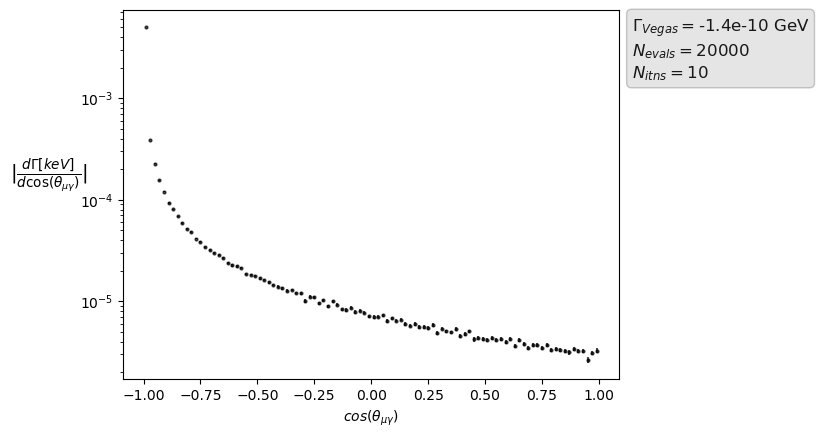

In [3]:
dIs = []
dI_errs = []

cos_s = []
for i in range(0, bins):
    cos_s += [-1 + (i + 0.5) * 2 / bins]
    
for i in range(0, bins):
    dIs += [total_rate['dI_cos'][i].mean]
    dI_errs += [total_rate['dI_cos'][i].sdev]
    
norm = 2 / bins
keV = 10 ** 6

fig, ax = plt.subplots()

ax.errorbar(cos_s, -keV * np.array(dIs) / norm, color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = keV * np.array(dI_errs) / norm)

textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(computed, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'|$\frac{d\Gamma[keV]}{d\cos(\theta_{\mu\gamma})}|$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\mu\gamma})$')
plt.show()

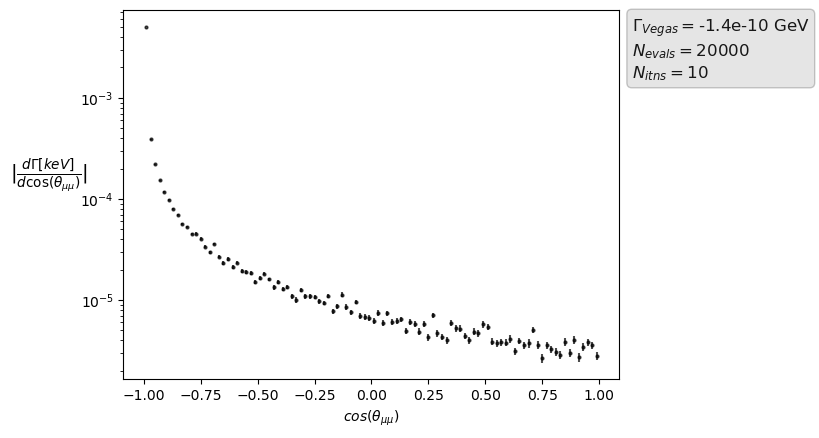

In [4]:
dIs = []
dI_errs = []

cos_s = []
for i in range(0, bins):
    cos_s += [-1 + (i + 0.5) * 2 / bins]
    
for i in range(0, bins):
    dIs += [total_rate['dI_cos_alt'][i].mean]
    dI_errs += [total_rate['dI_cos_alt'][i].sdev]

norm = 2 / bins
keV = 10 ** 6

fig, ax = plt.subplots()

ax.errorbar(cos_s, -keV * np.array(dIs) / norm, color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = keV * np.array(dI_errs) / norm)

textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(computed, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$|\frac{d\Gamma[keV]}{d\cos(\theta_{\mu\mu})}|$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\mu\mu})$')
plt.show()

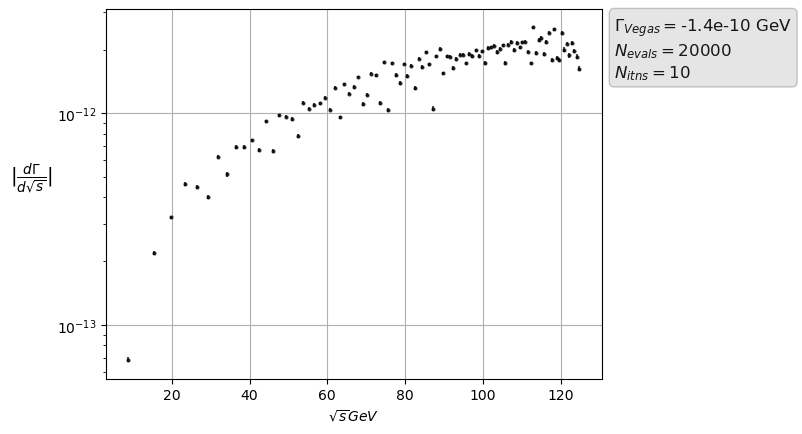

In [5]:
dIs = []
dI_errs = []
sqs = []
ss = []
for i in range(0, bins):
    ss += [s_min_fix + 0.5 * (s_max_fix - s_min_fix) / bins + i * (s_max_fix - s_min_fix) / bins]
    
sbins = []
for i in range(0, bins + 1):
    sbins += [i * (s_max_fix - s_min_fix) / bins]
    
sdbins = []
for i in range(0, bins):
    sdbins += [sbins[i + 1] ** 0.5 - sbins[i] ** 0.5]
    
for i in range(0, bins):
    dIs += [total_rate['dI'][i].mean / sdbins[i]]
    dI_errs += [total_rate['dI'][i].sdev / sdbins[i]]

sqs = np.array(ss) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqs, -np.array(dIs), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_errs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(computed, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')

plt.ylabel(r'$|\frac{d\Gamma}{d\sqrt{s}}|$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{s} GeV$')
#plt.ylim(10**-10, 10**-6)
#plt.xlim(0, 130)
plt.show()

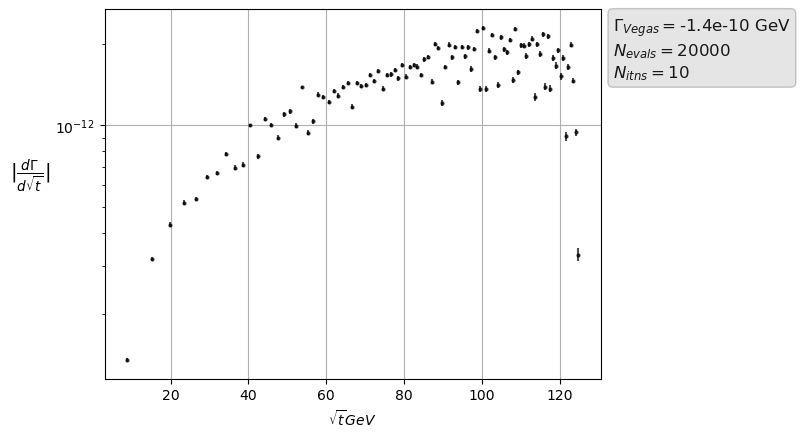

In [6]:
dI_ts = []
dI_terrs = []
sqt = []
ts = []
for i in range(0, bins):
    ts += [t_min_fix + 0.5 * (t_max_fix - t_min_fix) / bins + i * (t_max_fix - t_min_fix) / bins]
    
tbins = []
for i in range(0, bins + 1):
    tbins += [i * (t_max_fix - t_min_fix) / bins]
    
tdbins = []
for i in range(0, bins):
    tdbins += [tbins[i + 1] ** 0.5 - tbins[i] ** 0.5]
    
for i in range(0, bins):
    dI_ts += [total_rate['dI_t'][i].mean / tdbins[i]]
    dI_terrs += [total_rate['dI_t'][i].sdev / tdbins[i]]

sqt = np.array(ts) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqt, -np.array(dI_ts), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_terrs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(computed, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$|\frac{d\Gamma}{d\sqrt{t}}|$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{t} GeV$')
#plt.ylim(10**-11, 10**-6)
#plt.xlim(0, 130)
plt.show()